# Autoencoders for collaborative filtering

In [1]:
import pandas as pd
import numpy as np
import pickle

In [2]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

In [3]:
ratings=pd.read_csv('ratings.dat', sep='::', header=None, engine='python', encoding='latin-1')

In [4]:
ratings.columns=['userId','movieId', 'rating', 'timestamp']

In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392


In [6]:
ratings.shape

(10000054, 4)

In [7]:
print(f"full dataset:\nnumber users {int(ratings.userId.nunique())}, number movies {int(ratings.movieId.nunique())}")

full dataset:
number users 69878, number movies 10677


In [8]:
u_uniq = ratings.userId.unique()
user2idx = {o:i for i,o in enumerate(u_uniq)}
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

In [9]:
n_users=int(ratings.userId.nunique())
n_movies=int(ratings.movieId.nunique())
n_factors = 100
print(f"number users: {n_users}, number movies {n_movies}")

number users: 69878, number movies 10677


In [10]:
ratings.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

In [11]:
ratings_final=ratings.drop(['timestamp'],axis=1)
ratings_final=ratings_final.astype({"rating": np.float32})
ratings_final.head()

,userId,movieId,rating
0,0,0,5.0
1,0,1,5.0
2,0,2,5.0
3,0,3,5.0
4,0,4,5.0


In [12]:
def dataPreprocessor(rating_df, num_users, num_items, init_value=0, average=False):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
    """
    matrix = np.zeros((num_users, num_items),dtype='float32')
    for (_, userID, itemID, rating) in rating_df.itertuples():
        matrix[userID, itemID] = rating

    return matrix

# Get ratings of users-movies

In [13]:
new_data=dataPreprocessor(ratings_final, n_users,n_movies)

In [14]:
ratings_final=ratings_final.astype({"rating": np.float32})

In [15]:
new_data

array([[5., 5., 5., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 3., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [16]:
new_df=pd.DataFrame(new_data)

In [17]:
new_df.head()

,0,1,2,3,4,5,6,7,8,9,...,10667,10668,10669,10670,10671,10672,10673,10674,10675,10676
0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,3.0,5.0,5.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
new_df=new_df.transpose()

In [19]:
new_df.head()

,0,1,2,3,4,5,6,7,8,9,...,69868,69869,69870,69871,69872,69873,69874,69875,69876,69877
0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
2,5.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,1.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0
3,5.0,0.0,0.0,3.0,0.0,0.0,0.0,3.5,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,0.0,0.0,5.0,0.0,0.0,0.0,4.5,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0


In [20]:
new_df.to_pickle('new_df_matrix.pkl')

In [21]:
import pandas as pd
import numpy as np

import torch
import numpy as np
import pandas as pd
import pickle
import multiprocessing
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


def get_cv_idxs(n, cv_idx=0, val_pct=0.2, seed=42):
    """ Get a list of index values for Validation set from a dataset

    Arguments:
        n : int, Total number of elements in the data set.
        cv_idx : int, starting index [idx_start = cv_idx*int(val_pct*n)]
        val_pct : (int, float), validation set percentage
        seed : seed value for RandomState

    Returns:
        list of indexes
    """
    np.random.seed(seed)
    n_val = int(val_pct * n)
    idx_start = cv_idx * n_val
    idxs = np.random.permutation(n)
    return idxs[idx_start:idx_start + n_val]


def split_by_idx(idxs, *a):
    """
    Split each array passed as *a, to a pair of arrays like this (elements selected by idxs,  the remaining elements)
    This can be used to split multiple arrays containing training data to validation and training set.

    :param idxs [int]: list of indexes selected
    :param a list: list of np.array, each array should have same amount of elements in the first dimension
    :return: list of tuples, each containing a split of corresponding array from *a.
            First element of each tuple is an array composed from elements selected by idxs,
            second element is an array of remaining elements.
    """
    mask = np.zeros(len(a[0]), dtype=bool)
    mask[np.array(idxs)] = True
    return [(o[mask], o[~mask]) for o in a]


class AutoEncoder(object):

    def __init__(self, data, validation_perc=0.2, lr=0.001,
                 intermediate_size=1000, encoded_size=100):

        # create training dataloader and validation tensor
        self.data = data
        self.val_idxs = get_cv_idxs(n=data.shape[0], val_pct=validation_perc)
        [(self.val, self.train)] = split_by_idx(self.val_idxs, data)
        self.dataset = AETrainingData(self.train)
        self.dataloader = DataLoader(self.dataset, batch_size=64, shuffle=True,
                                     num_workers=multiprocessing.cpu_count())
        #print('datal=',self.dataloader)
        self.val = torch.from_numpy(self.val.values).\
            type(torch.FloatTensor).cuda()

        # instantiate the encoder and decoder nets
        size = data.shape[1]
        self.encoder = Encoder(size, intermediate_size, encoded_size).cuda()
        self.decoder = Decoder(size, intermediate_size, encoded_size).cuda()

        # instantiate the optimizers
        self.encoder_optimizer = optim.Adam(
            self.encoder.parameters(), lr=lr, weight_decay=1e-8)
        self.decoder_optimizer = optim.Adam(
            self.decoder.parameters(), lr=lr, weight_decay=1e-8)

        # instantiate the loss criterion
        self.criterion = nn.MSELoss(reduction='mean')

        self.train_losses = []
        self.val_losses = []

    def train_step(self, input_tensor, target_tensor):
        # clear the gradients in the optimizers
        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()

        # Forward pass through
        encoded_representation = self.encoder(input_tensor)
        reconstruction = self.decoder(encoded_representation)

        # Compute the loss
        loss = self.criterion(reconstruction, target_tensor)

        # Compute the gradients
        loss.backward()

        # Step the optimizers to update the model weights
        self.encoder_optimizer.step()
        self.decoder_optimizer.step()

        # Return the loss value to track training progress
        return loss.item()
    
    def reset(self, train=True):
        # due to dropout the network behaves differently in training and
        # evaluation modes
        if train: self.encoder.train(); self.decoder.train()
        else: self.encoder.eval(); self.decoder.eval()

    def get_val_loss(self, input_tensor, target_tensor):
        self.reset(train=False)
        encoded = self.encoder(input_tensor)
        decoded = self.decoder(encoded)
        loss = self.criterion(decoded, target_tensor)
        return loss.item()

    def train_loop(self, epochs, print_every_n_batches=20):

        # Cycle through epochs
        for epoch in range(epochs):
            print(f'Epoch {epoch + 1}/{epochs}')

            # Cycle through batches
            for i, batch in enumerate(self.dataloader):
                #print(i,batch)
                
                self.reset(train=True)

                input_tensor = batch['input'].cuda()
                target_tensor = batch['target'].cuda()

                loss = self.train_step(input_tensor, target_tensor)

                if i % print_every_n_batches == 0 and i != 0:
                    #print('i=',i)
                    val_loss = self.get_val_loss(self.val, self.val)
                    print(f'train loss: {round(loss, 8)} | ' +
                          f'validation loss: {round(val_loss, 8)}')
                    self.train_losses.append(loss)
                    self.val_losses.append(val_loss)

    def get_encoded_representations(self):
        to_encode = torch.from_numpy(self.data.values).type(
            torch.FloatTensor).cuda()
        self.reset(train=False)
        encodings = self.encoder(to_encode).cpu().data.numpy()
        return encodings


class AETrainingData(Dataset):
    """
    Format the training dataset to be input into the auto encoder.
    Takes in dataframe and converts it to a PyTorch Tensor
    """

    def __init__(self, x_train):
        self.x = x_train

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        """
        Returns a example from the data set as a pytorch tensor.
        """
        # Get example/target pair at idx as numpy arrays
        x, y = self.x.iloc[idx].values, self.x.iloc[idx].values

        # Convert to torch tensor
        x = torch.from_numpy(x).type(torch.FloatTensor)
        y = torch.from_numpy(y).type(torch.FloatTensor)

        # Return pair
        return {'input': x, 'target': y}


class Encoder(nn.Module):
    def __init__(self, input_size, intermediate_size, encoding_size):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, intermediate_size),
            nn.BatchNorm1d(intermediate_size),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(intermediate_size, encoding_size),
            nn.BatchNorm1d(encoding_size),
            nn.ReLU(True),
            nn.Dropout(0.2))

    def forward(self, x):
        x = self.encoder(x)
        return x


class Decoder(nn.Module):
    def __init__(self, output_size, intermediate_size, encoding_size):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(encoding_size, intermediate_size),
            nn.BatchNorm1d(intermediate_size),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(intermediate_size, output_size),
            nn.BatchNorm1d(output_size),
            nn.Sigmoid())

    def forward(self, x):
        x = self.decoder(x)
        return x


In [22]:
with open(f'new_df_matrix.pkl', 'rb') as fh:
    new_df1 = pickle.load(fh)

# Normalizing data

In [23]:
ndf=new_df1

In [24]:
ndf=ndf.apply(lambda x: x/x.max(), axis=0)

In [25]:
ndf.head()

,0,1,2,3,4,5,6,7,8,9,...,69868,69869,69870,69871,69872,69873,69874,69875,69876,69877
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.6,0.0
2,1.0,0.0,0.0,0.2,0.0,0.0,0.0,0.6,0.0,0.0,...,0.0,0.0,0.2,0.0,0.4,0.0,0.6,0.0,0.0,0.0
3,1.0,0.0,0.0,0.6,0.0,0.0,0.0,0.7,0.0,0.0,...,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.9,0.0,0.0,...,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.6,0.8


# Training autoencoder

In [26]:
ae_4 = AutoEncoder(ndf, validation_perc=0.1, lr=1e-3, intermediate_size=1000, encoded_size=100)

In [27]:
ae_4.train_loop(epochs=100)

Epoch 1/100
train loss: 0.22617254 | validation loss: 0.23807712
train loss: 0.21706323 | validation loss: 0.20859787
train loss: 0.21245661 | validation loss: 0.21516648
train loss: 0.20896207 | validation loss: 0.20395066
train loss: 0.20248421 | validation loss: 0.19462794
train loss: 0.20033619 | validation loss: 0.18713266
train loss: 0.19620705 | validation loss: 0.19106838
Epoch 2/100
train loss: 0.19338351 | validation loss: 0.17798558
train loss: 0.18383874 | validation loss: 0.17882702
train loss: 0.1834074 | validation loss: 0.16893016
train loss: 0.17768133 | validation loss: 0.17423619
train loss: 0.16744727 | validation loss: 0.16310669
train loss: 0.17218275 | validation loss: 0.16045925
train loss: 0.16381782 | validation loss: 0.15459284
Epoch 3/100
train loss: 0.15874931 | validation loss: 0.15456828
train loss: 0.15550807 | validation loss: 0.14834727
train loss: 0.16020785 | validation loss: 0.14320716
train loss: 0.14839482 | validation loss: 0.14249596
train loss:

# Saving for different parameters

In [ ]:
losses3 = pd.DataFrame(data=list(zip(ae_4.train_losses, ae_4.val_losses)), columns=['train_loss', 'validation_loss'])
losses3['epoch'] = (losses3.index + 1) / 3

In [ ]:
losses3.to_csv('batch64.csv')

In [ ]:
losses128 = pd.DataFrame(data=list(zip(ae_4.train_losses, ae_4.val_losses)), columns=['train_loss', 'validation_loss'])
losses128['epoch'] = (losses128.index + 1) / 3

In [ ]:
losses128.to_csv('batch128.csv')

In [ ]:
losses256 = pd.DataFrame(data=list(zip(ae_4.train_losses, ae_4.val_losses)), columns=['train_loss', 'validation_loss'])
losses256['epoch'] = (losses256.index + 1) / 3

In [ ]:
losses256.to_csv('batch256.csv')

In [ ]:
lossesSELU = pd.DataFrame(data=list(zip(ae_4.train_losses, ae_4.val_losses)), columns=['train_loss', 'validation_loss'])
lossesSELU['epoch'] = (lossesSELU.index + 1) / 3

In [ ]:
lossesSELU.to_csv('ActSELU.csv')

In [ ]:
lossesTanh = pd.DataFrame(data=list(zip(ae_4.train_losses, ae_4.val_losses)), columns=['train_loss', 'validation_loss'])
lossesTanh['epoch'] = (lossesTanh.index + 1) / 3

In [ ]:
lossesTanh.to_csv('ActTanh.csv')

# Plotting single loss

In [28]:
losses = pd.DataFrame(data=list(zip(ae_4.train_losses, ae_4.val_losses)), columns=['train_loss', 'validation_loss'])
losses['epoch'] = (losses.index + 1) / 3

Text(0.5, 1.0, 'autoencoder loss over time')

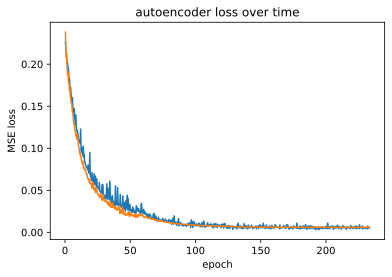

In [30]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'
fig, ax = plt.subplots()
ax.plot(losses['epoch'], losses['train_loss'])
ax.plot(losses['epoch'], losses['validation_loss'])
ax.set_ylabel('MSE loss')
ax.set_xlabel('epoch')
ax.set_title('autoencoder loss over time')

In [31]:
encoded4 = ae_4.get_encoded_representations()

In [32]:
with open('autoencoder_collaborative_embeddings.pkl', 'wb') as fh:
    pickle.dump(encoded4, fh)

In [ ]:
import pandas
df1 = pandas.read_csv('batch64.csv')

In [ ]:
import pandas
df2 = pandas.read_csv('batch128.csv')

In [ ]:
import pandas
df3 = pandas.read_csv('batch256.csv')

In [ ]:
import pandas
df4 = pandas.read_csv('ActSELU.csv')

In [ ]:
import pandas
df5 = pandas.read_csv('ActTanh.csv')

In [ ]:
df4

# Plotting Training

In [ ]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'
fig, ax = plt.subplots()
ax.plot(df1['epoch'], df1['train_loss'], label = "Activation: ReLU")

ax.plot(df4['epoch'], df4['train_loss'], label = "Activation: SELU")

ax.plot(df5['epoch'], df5['train_loss'], label = "Activation: Tanh")

# ax.plot(losses5['epoch'], losses5['train_loss'], label = "LR = 1e-5")

ax.set_ylabel('MSE loss')
ax.set_xlabel('Epoch')
ax.legend()
ax.set_title('Autoencoder loss for Training')

# Plotting Validation

In [ ]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'
fig, ax = plt.subplots()

ax.plot(df1['epoch'], df1['validation_loss'], label = "Activation: ReLU")

ax.plot(df4['epoch'], df4['validation_loss'], label = "Activation: SELU")

ax.plot(df5['epoch'], df5['validation_loss'], label = "Activation: Tanh")


# ax.plot(losses5['epoch'], losses5['validation_loss'], label = "LR = 1e-5")

ax.set_ylabel('MSE loss')
ax.set_xlabel('Epoch')
ax.legend()
ax.set_title('Autoencoder loss for Validation')